In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.externals import joblib

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale
import os

import codecs


import scikitplot as skplt
from sklearn.feature_selection import SelectKBest, chi2

In [3]:
# Optuna
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Set seed value
random_seed= 123
#42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(random_seed)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(random_seed)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(random_seed)

## Load Dataset

In [6]:
## CTDC

ctdc_train_N = pd.read_csv('C:/Users/nchandra/OneDrive - National University of Singapore/FYP/BioStatsFYP/PredProtein/311020 FYP/data/ctdc_train_N.csv',header = None)
ctdc_train_N['target'] = 0

ctdc_train_P = pd.read_csv('C:/Users/nchandra/OneDrive - National University of Singapore/FYP/BioStatsFYP/PredProtein/311020 FYP/data/ctdc_train_P.csv', header = None)
ctdc_train_P['target'] = 1

ctdc_train = pd.concat([ctdc_train_P.iloc[:,1:], ctdc_train_N.iloc[:,1:]], axis = 0)
ctdc_train.reset_index(drop = True, inplace = True)
ctdc_train['target'] = ctdc_train['target'].astype('category')

ctdc_X = ctdc_train.drop('target', axis = 1)
ctdc_y = ctdc_train['target']

In [7]:
# independent test data


ctdc_test_N = pd.read_csv('C:/Users/nchandra/OneDrive - National University of Singapore/FYP/BioStatsFYP/PredProtein/311020 FYP/data/ctdc_test_N.csv', header = None)
ctdc_test_N['target'] = 0

ctdc_test_P = pd.read_csv('C:/Users/nchandra/OneDrive - National University of Singapore/FYP/BioStatsFYP/PredProtein/311020 FYP/data/ctdc_test_P.csv', header = None)
ctdc_test_P['target'] = 1

ctdc_test = pd.concat([ctdc_test_P.iloc[:,1:], ctdc_test_N.iloc[:,1:]], axis = 0)
ctdc_test.reset_index(drop = True, inplace = True)

ctdc_indX_test = ctdc_test.drop('target', axis = 1)

ctdc_indy_test = ctdc_test['target']


### Training and Test Data Scaling

In [8]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

In [9]:
# training data
X_train = minmax.fit_transform(ctdc_X)
X_train = pd.DataFrame(X_train, index  = ctdc_X.index)
y_train = ctdc_y

In [10]:

X_test = minmax.fit_transform(ctdc_indX_test)
X_test = pd.DataFrame(X_test, index = ctdc_indX_test.index)
y_test = ctdc_indy_test

### Feature Selection for Sequence with large Attribute > 100

In [11]:
def feat_select(X_train, y_train): 
    
    from sklearn.feature_selection import SelectFromModel
    from numpy import sort

    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)

    thresholds = np.sort(xgb.feature_importances_)[::-1]

    feature_thresh = pd.DataFrame(columns = ['Thresh', 'n', 'Accuracy'])
    columns = list(feature_thresh)
    data = []

    thresh_limit = 1

    for thresh in thresholds:

        #to Stop the loop if the threshold no longer improves

        if thresh >= thresh_limit:
            break

        #select features using threshold
        selection =  SelectFromModel(xgb, threshold = thresh, prefit = True)
        select_X_train = selection.transform(X_train)

        #train model
        selection_model = XGBClassifier()
        selection_model.fit(select_X_train, y_train)

        #evaluate model
        select_X_test = selection.transform(X_test)
        predictions = selection_model.predict(select_X_test)
        accuracy = accuracy_score(y_test, predictions)


        #print("Thresh = %.3f, n = %d, Accuracy = %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

        thresh_limit = thresh

        values = [thresh, select_X_train.shape[1], accuracy*100]
        zipped = zip(columns, values)
        values_dict = dict(zipped)
        data.append(values_dict)

    feature_thresh = feature_thresh.append(data, True)

    best_accuracy = feature_thresh[feature_thresh['Accuracy'] == feature_thresh['Accuracy'].max()]
    best_threshold = best_accuracy.Thresh.min()

    # transform training data based on the selected feature importances
    best_thresh = SelectFromModel(xgb, threshold = best_threshold, prefit = True)
    
    X_train_best = pd.DataFrame(best_thresh.transform(X_train))
    X_test_best = pd.DataFrame(best_thresh.transform(X_test))

    return X_train_best, X_test_best


In [12]:
#X_train_best, X_test_best = feat_select(X_train, y_train)

In [13]:
if X_train.shape[1] > 100:
    X_train, X_test = feat_select(X_train, y_train)

## Stacking Ensemble Classifier - 1

In [14]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    #level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))

    level0.append(('lsvm', LinearSVC(random_state = random_seed)))
    level0.append(('svm', SVC(random_state = random_seed)))
    level0.append(('et', ExtraTreesClassifier(random_state = random_seed)))
    level0.append(('rf', RandomForestClassifier(random_state = random_seed)))

    level0.append(('xgbC', XGBClassifier()))
    
    # define meta learner model
    level1 = LogisticRegression(random_state = random_seed)
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [15]:
def get_models():
    models = dict()
    #models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()

    models['lsvm'] = LinearSVC(C=15.0, dual=False, 
                               loss='squared_hinge', 
                               penalty='l2', tol=0.01,
                              random_state = random_seed)
    models['et'] = ExtraTreesClassifier(bootstrap=False, 
                     criterion = 'gini', 
                     max_features=0.35000000000000003, 
                     min_samples_leaf= 1, 
                     min_samples_split=2, 
                     n_estimators=100,
                                       random_state = random_seed)
    
    models['rf'] = RandomForestClassifier(random_state = random_seed)
    models['svm'] = SVC()

    models['xgbC'] = XGBClassifier()
    models['stacking'] = get_stacking()
    return models

In [16]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, 
                             scoring='roc_auc', 
                             cv=cv, 
                             n_jobs=-1, 
                             error_score='raise')
    return scores

In [17]:
# get the models to evaluate
models = get_models()

In [18]:
# Result on Train Set Cross Validation
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, 
                            X_train, 
                            y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.4f (%.4f)' % (name, 
                               mean(scores), 
                               std(scores)))

>knn 0.9122 (0.0401)
>lsvm 0.9353 (0.0383)
>et 0.9306 (0.0302)
>rf 0.9202 (0.0354)
>svm 0.9229 (0.0400)
>xgbC 0.9256 (0.0330)
>stacking 0.9348 (0.0356)


In [19]:
# Result on Test Set
results, names = list(), list()
for name, model in models.items():
    mod = model.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    
    fpr,tpr,thresholds = metrics.roc_curve(y_test, 
                                           y_pred, 
                                           pos_label = 1)
    auc = metrics.auc(fpr,tpr)
    
    results.append(auc)
    names.append(name)
    print('>%s %.4f' % (name, auc))

>knn 0.7059
>lsvm 0.7941
>et 0.7647
>rf 0.7500
>svm 0.7500
>xgbC 0.7500
>stacking 0.8676


## Stacking Ensemble Classifier - 2

In [20]:
# get a stacking ensemble of models
def get_stacking2():
    # define the base models
    level0 = list()
    #level0.append(('lr', LogisticRegression()))
    #level0.append(('knn', KNeighborsClassifier()))

    level0.append(('lsvm', LinearSVC(random_state = random_seed)))
    #level0.append(('svm', SVC()))
    level0.append(('et', ExtraTreesClassifier(random_state = random_seed)))
    level0.append(('rf', RandomForestClassifier(random_state = random_seed)))

    #level0.append(('xgbC', XGBClassifier()))
    
    # define meta learner model
    level1 = LogisticRegression(random_state = random_seed)
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [21]:
def get_models2():
    models = dict()
    #models['lr'] = LogisticRegression()
    #models['knn'] = KNeighborsClassifier()

    models['lsvm'] = LinearSVC(C=15.0, dual=False, 
                               loss='squared_hinge', 
                               penalty='l2', tol=0.01, 
                               random_state = random_seed)
    models['et'] = ExtraTreesClassifier(bootstrap=False, 
                     criterion = 'entropy', 
                     max_features=0.35000000000000003, 
                     min_samples_leaf=18, 
                     min_samples_split=9, 
                     n_estimators=100,
                        random_state = random_seed)
    
    models['rf'] = RandomForestClassifier(random_state = random_seed)
    #models['svm'] = SVC()

    #models['xgbC'] = XGBClassifier()
    models['stacking'] = get_stacking()
    return models

In [22]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, 
                             scoring='roc_auc', 
                             cv=cv, 
                             n_jobs=-1, 
                             error_score='raise')
    return scores

In [23]:
# get the models to evaluate
models = get_models2()

In [24]:
# Result on Train Set Cross Validation
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, 
                            X_train, 
                            y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.4f (%.4f)' % (name, 
                               mean(scores), 
                               std(scores)))

>lsvm 0.9353 (0.0383)
>et 0.9127 (0.0399)
>rf 0.9202 (0.0354)
>stacking 0.9348 (0.0356)


In [25]:
# Result on Test Set
results, names = list(), list()
for name, model in models.items():
    mod = model.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    
    fpr,tpr,thresholds = metrics.roc_curve(y_test, 
                                           y_pred, 
                                           pos_label = 1)
    auc = metrics.auc(fpr,tpr)
    
    results.append(auc)
    names.append(name)
    print('>%s %.4f' % (name, auc))

>lsvm 0.7941
>et 0.7206
>rf 0.7500
>stacking 0.8676


## Stacking Ensemble Classifier - 3

In [26]:
# get a stacking ensemble of models
def get_stacking3():
    # define the base models
    level0 = list()
    #level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))

    level0.append(('lsvm', LinearSVC(random_state = random_seed)))
    #level0.append(('svm', SVC()))
    level0.append(('et', ExtraTreesClassifier(random_state = random_seed)))
    level0.append(('rf', RandomForestClassifier(random_state = random_seed)))

    #level0.append(('xgbC', XGBClassifier()))
    
    # define meta learner model
    level1 = LogisticRegression(random_state = random_seed)
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [27]:
def get_models3():
    models = dict()
    #models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()

    models['lsvm'] = LinearSVC(C=15.0, dual=False, 
                               loss='squared_hinge', 
                               penalty='l2', tol=0.01,
                              random_state = random_seed)
    models['et'] = ExtraTreesClassifier(bootstrap=False, 
                     criterion = 'entropy', 
                     max_features=0.35000000000000003, 
                     min_samples_leaf=18, 
                     min_samples_split=9, 
                     n_estimators=100,
                                       random_state = random_seed)
    
    models['rf'] = RandomForestClassifier(random_state = random_seed)
    #models['svm'] = SVC()

    #models['xgbC'] = XGBClassifier()
    models['stacking'] = get_stacking()
    return models

In [28]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, 
                             scoring='roc_auc', 
                             cv=cv, 
                             n_jobs=-1, 
                             error_score='raise')
    return scores

In [29]:
# get the models to evaluate
models = get_models3()

In [30]:
# Result on Train Set Cross Validation
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, 
                            X_train, 
                            y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.4f (%.4f)' % (name, 
                               mean(scores), 
                               std(scores)))

>knn 0.9122 (0.0401)
>lsvm 0.9353 (0.0383)
>et 0.9127 (0.0399)
>rf 0.9202 (0.0354)
>stacking 0.9348 (0.0356)


In [31]:
# Result on Test Set
results, names = list(), list()
for name, model in models.items():
    mod = model.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    
    fpr,tpr,thresholds = metrics.roc_curve(y_test, 
                                           y_pred, 
                                           pos_label = 1)
    auc = metrics.auc(fpr,tpr)
    
    results.append(auc)
    names.append(name)
    print('>%s %.4f' % (name, auc))

>knn 0.7059
>lsvm 0.7941
>et 0.7206
>rf 0.7500
>stacking 0.8676


## Bayesian Hyperparameter Optimization - Optuna

Random Forest

In [32]:
rf_trial = 40

def objective_rf(trial: Trial, X, y):

    param = {
        
        'criterion':trial.suggest_categorical('criterion', ['gini', 'entropy']),
        "n_estimators": trial.suggest_int('n_estimators', 10,1000),
        "max_depth" : trial.suggest_int('max_depth', 5, 50),
        'max_features':trial.suggest_categorical('max_features', ['auto', 'sqrt']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': random_seed
        }
    
    model = RandomForestClassifier(**param)
     
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state= random_seed)
    
    return cross_val_score(model, 
                           X, 
                           y, 
                           cv = cv, 
                           scoring = 'roc_auc',
                           n_jobs=-1).mean()

In [33]:
study_rf = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = random_seed))

## to be run once. Takes about 40 mins

#study_rf.optimize(lambda trial: objective_rf(trial, X_train, y_train), n_trials = rf_trial)

#print('Best trial: score {}, \nparams{}'.format(study_rf.best_trial.value, study_rf.best_trial.params))

#joblib.dump(study_rf.best_trial.params, '4ctdc_rf_best.pkl', compress = 1)

[I 2020-10-31 22:31:38,755] A new study created in memory with name: no-name-a4888018-65fa-446b-9285-b3bdae42f1cb


Linear SVM

In [34]:
lsvm_trial = 100

def objective_lsvm(trial: Trial, X, y):


    param = {
        'C': trial.suggest_loguniform('C', 2 ** -10, 2 ** 15),
        'tol': trial.suggest_loguniform('tol', 2 ** -20, 2 ** 10),
        'max_iter': trial.suggest_int('max_iter', 100, 5000),
        'random_state':random_seed
    }
    
    model = LinearSVC(**param)
    
    #model.fit(train_X, train_y)
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state= random_seed)
    
    return cross_val_score(model, 
                           X, 
                           y, 
                           cv = cv, 
                           scoring = 'roc_auc',
                           n_jobs=-1).mean()


In [35]:
study_lsvm = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = random_seed))

## To be run once. Takes 3 mins
#study_lsvm.optimize(lambda trial: objective_lsvm(trial, X_train, y_train), n_trials = lsvm_trial)
#print('Best trial: score {}, \nparams{}'.format(study_lsvm.best_trial.value, study_lsvm.best_trial.params))
#joblib.dump(study_lsvm.best_trial.params, '4ctdc_lsvm_best.pkl', compress = 1)

[I 2020-10-31 22:31:38,786] A new study created in memory with name: no-name-331f39d4-1316-4c22-97ef-68615f42421d


Extra Trees Classifier

In [36]:
et_trial = 50

def objective_et(trial: Trial, X, y):

    
    param = {
        
        'criterion':trial.suggest_categorical('criterion', ['gini', 'entropy']),
        "n_estimators": trial.suggest_int('n_estimators', 10,1000),
        "max_depth" : trial.suggest_int('max_depth', 5, 50),
        #'min_weight_fraction_leaf':trial.suggest_uniform('min_weight_fraction_leaf',0.0, 1.0),
        'max_features':trial.suggest_categorical('max_features', ['auto', 'sqrt']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': random_seed
        }
    
    model = ExtraTreesClassifier(**param)
    
    #model.fit(train_X, train_y)
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state= random_seed)
    
    return cross_val_score(model, 
                           X, 
                           y, 
                           cv = cv, 
                           scoring = 'roc_auc',
                           n_jobs=-1).mean()

In [37]:
study_et = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = random_seed))

## To be run once. Takes about 30 mins
#study_et.optimize(lambda trial: objective_et(trial, X_train, y_train), n_trials = et_trial)
#print('Best trial: score {}, \nparams{}'.format(study_et.best_trial.value, study_et.best_trial.params))

## save best param
#joblib.dump(study_et.best_trial.params, '4ctdc_et_best.pkl', compress = 1)

[I 2020-10-31 22:31:38,815] A new study created in memory with name: no-name-155022dd-8cf4-4f83-bfea-002db55fb3f6


## Load Pre-trained Optimized Hyperparameters

In [38]:
rf_best = joblib.load('4ctdc_rf_best.pkl')

In [39]:
lsvm_best = joblib.load('4ctdc_lsvm_best.pkl')

In [40]:
et_best = joblib.load('4ctdc_et_best.pkl')

## Stacking Ensemble Model on Optimized Base Models

In [41]:
#get a stacking ensemble of models
def get_stacking_final():
    # define the base models
    level0 = list()

    level0.append(('lsvm', LinearSVC().set_params(**lsvm_best)))

    level0.append(('et', ExtraTreesClassifier().set_params(**et_best)))
    
    level0.append(('rf', RandomForestClassifier().set_params(**rf_best)))

    # define meta learner model
    level1 = LogisticRegression(random_state = random_seed)
    
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [42]:
def get_models_final():
    models = dict()

    models['lsvm'] = LinearSVC().set_params(**lsvm_best)

    models['et'] = ExtraTreesClassifier().set_params(**et_best)
    
    models['rf'] = RandomForestClassifier().set_params(**rf_best)

    models['stacking'] = get_stacking_final()
    return models

In [43]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_seed)
    scores = cross_val_score(model, X, y, 
                             scoring='roc_auc', 
                             cv=cv, 
                             n_jobs=-1, 
                             error_score='raise')
    return scores

In [44]:
# get the models to evaluate on cross validated train set
models_final = get_models_final()

for name, model in models_final.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lsvm 0.936 (0.035)
>et 0.938 (0.033)
>rf 0.937 (0.032)
>stacking 0.941 (0.034)


>lsvm AUC: 0.779 Accuracy: 0.779 f1: 0.783 precision: 0.771 recall: 0.794
>et AUC: 0.750 Accuracy: 0.750 f1: 0.667 precision: 1.000 recall: 0.500
>rf AUC: 0.706 Accuracy: 0.706 f1: 0.583 precision: 1.000 recall: 0.412
>stacking AUC: 0.882 Accuracy: 0.882 f1: 0.867 precision: 1.000 recall: 0.765


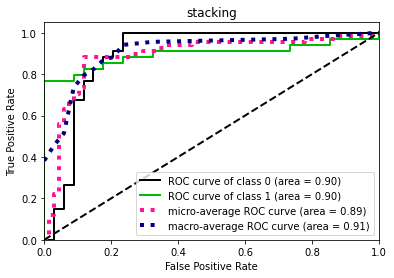

In [45]:
# on Independent Test Set
results, names, tprate, fprate, accuracy, f1, precision, recall = list(), list(), list(), list(), list(), list(), list(), list()
for name, model in models_final.items():
    mod = model.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
   
    fpr, tpr, thresholds  = metrics.roc_curve(y_test, 
                                              y_pred, 
                                              pos_label=1)
    
    acc = metrics.accuracy_score(y_test, y_pred)
    f = metrics.f1_score(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    
    results.append(auc)
    names.append(name)
    tprate.append(tpr)
    fprate.append(fpr)
    accuracy.append(acc)
    f1.append(f)
    precision.append(prec)
    recall.append(rec)
    
    print('>%s AUC: %.3f Accuracy: %.3f f1: %.3f precision: %.3f recall: %.3f' % (name, auc, acc, f, prec, rec))
    
    if name == 'stacking':
        y_pred_proba = mod.predict_proba(X_test)
        skplt.metrics.plot_roc(y_test, y_pred_proba)
        plt.title(name)
        plt.show()
    

In [46]:
test_result = pd.DataFrame(list(zip(names, results, tprate, fprate)),
              columns=['model','AUC', 'TPR', 'FPR'])

### ROC - AUC Curve for individual models and the Stacked Model

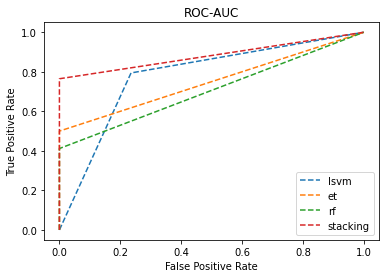

In [47]:
# plot the roc curve for the model

for index, row in test_result.iterrows():
    
    plt.plot(row['FPR'], row['TPR'], linestyle='--', label= row['model'])
    

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC')
    # show the legend
    plt.legend()

### Confusion Matrix for Optimized Stacking Model

In [48]:
cf_matrix = metrics.confusion_matrix(y_test, y_pred)

In [49]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

<AxesSubplot:>

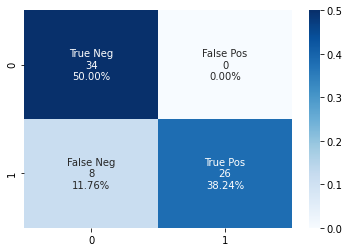

In [50]:
import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, 
           fmt='', cmap='Blues')

Ref Material:<br>
- Nice Confusion Matrix: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py <br>
- Scikit Plot: https://github.com/reiinakano/scikit-plot